
# Classificação de categoria de jogos da Steam
## Projeto da disciplina SCC0230 - Inteligência Artificial
Membros
Alexandre Eduardo de Souza Jesus - alexandre_souza@usp.br - 12559506

Arthur Santorum Lorenzetto - arts.lorenzetto@usp.br - 12559465

Eduardo Zaffari Monteiro - eduardozaffarimonteiro@usp.br - 12559490(Vice-Líder)

Gustavo Silva de Oliveira - gustavo.oliveira03@usp.br - 12567231 

Lucas Ivars Cadima Ciziks - luciziks@usp.br - 125599472 

Pedro Henrique de Freitas Maçonetto - pedromaconetto@usp.br - 12675419(Líder)

Vitor Okubo Ianella - vitorok.03@gmail.com - 12559451


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('steam_metadados.csv')

---
## Limpando Dados

In [3]:
# Removendo colunas inúteis
df.drop(columns=['appid','steamspy_tags','platforms','developer',	'publisher','achievements'],inplace=True)

In [4]:
# Removendo Nan(é apenas um jogo)
df.dropna(inplace=True)

In [5]:
# Iremos utilizar classificação apenas para o primeiro gênero
df['genres'] = df['genres'].apply(lambda x: str(x).split(';')[0])

In [6]:
# Total de avaliações de um jogo
df['total_ratings'] = df['positive_ratings'] + df['negative_ratings'] 

In [7]:
# Reestruturando valores de idade mínima
def age_transform(age):
  age = int(age)
  if age == 3 or age == 7:
    return 0
  else:
    return age
  
df['required_age'] = df['required_age'].apply(age_transform)

In [8]:
# Jogo Singleplayer ou Multiplayer
def multi_or_single(cat):
  cat = str(cat).split(';')
  if 'Multi-player' in cat:
    return 1 # Multiplayer
  else:
    return 0 # Singleplayer

df['type']=df['categories'].apply(multi_or_single)
del df['categories']

In [9]:
# Estimativa do número de compradores
def media_comprador(texto):
    txt_min, txt_max = texto.split('-')
    return (int(txt_max) + int(txt_min))/2
    
df['owners'] =  df['owners'].apply(media_comprador)

In [10]:
# Ano de lançamento 
df['year_release'] = df['release_date'].apply(lambda x: str(x).split('-')[0])

In [11]:
df['eh_acao'] = np.where(df['genres'] == 'Action', 1, 0)

---
## DataFrame Limpo:

In [12]:
df.head()

,name,release_date,english,required_age,genres,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,type,year_release,eh_acao
0,Counter-Strike,2000-11-01,1,0,Action,124534,3339,17612,317,15000000.0,7.19,127873,1,2000,1
1,Team Fortress Classic,1999-04-01,1,0,Action,3318,633,277,62,7500000.0,3.99,3951,1,1999,1
2,Day of Defeat,2003-05-01,1,0,Action,3416,398,187,34,7500000.0,3.99,3814,1,2003,1
3,Deathmatch Classic,2001-06-01,1,0,Action,1273,267,258,184,7500000.0,3.99,1540,1,2001,1
4,Half-Life: Opposing Force,1999-11-01,1,0,Action,5250,288,624,415,7500000.0,3.99,5538,1,1999,1


In [13]:
df.corr()

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_21016\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,english,required_age,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,type,eh_acao
english,1.000000,0.002616,0.006001,0.005705,0.000338,-0.003416,0.010820,0.007716,0.006171,0.039118,0.070868
required_age,0.002616,1.000000,0.060592,0.057764,0.034547,0.014819,0.074703,0.119812,0.062333,0.024721,0.037198
positive_ratings,0.006001,0.060592,1.000000,0.762804,0.157898,0.035776,0.713448,0.036110,0.992340,0.061974,0.029229
negative_ratings,0.005705,0.057764,0.762804,1.000000,0.161140,0.047887,0.690306,0.051259,0.836842,0.067683,0.031306
average_playtime,0.000338,0.034547,0.157898,0.161140,1.000000,0.914900,0.174157,0.049242,0.164463,0.050282,0.000029
median_playtime,-0.003416,0.014819,0.035776,0.047887,0.914900,1.000000,0.035983,0.036610,0.039437,0.032173,-0.008312
owners,0.010820,0.074703,0.713448,0.690306,0.174157,0.035983,1.000000,0.031071,0.735892,0.097278,0.046472
price,0.007716,0.119812,0.036110,0.051259,0.049242,0.036610,0.031071,1.000000,0.040363,0.117571,0.005656
total_ratings,0.006171,0.062333,0.992340,0.836842,0.164463,0.039437,0.735892,0.040363,1.000000,0.065399,0.030727
type,0.039118,0.024721,0.061974,0.067683,0.050282,0.032173,0.097278,0.117571,0.065399,1.000000,0.132712


---
## Modelo de KNN para os dados:

In [14]:
y = df['eh_acao']
X = df[['english', 'type', 'total_ratings', 'owners', 'price', 'median_playtime', 'year_release']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

### Plot para definir o K

In [15]:
scores = []
for i in range(20,30,1):
  neigh = KNeighborsClassifier(n_neighbors=i)
  neigh.fit(X_train, y_train)
  score = neigh.score(X_test,y_test,sample_weight=None)
  scores.append(score)

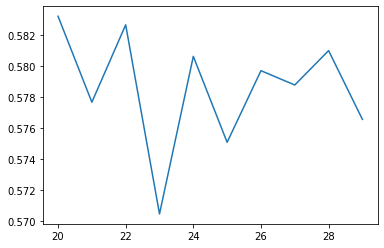

In [16]:
plt.plot(range(20,30,1),scores)

In [17]:
neigh = KNeighborsClassifier(n_neighbors=21,p=3)
neigh.fit(X_train, y_train)
results = neigh.predict(X_test)

In [18]:
neigh.score(X_test,y_test,sample_weight=None)

0.5748845798707295

---
### Medidas de avaliação do modelo:

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

matrix = confusion_matrix(y_test,results)
matrix

array([[2537,  636],
       [1666,  576]], dtype=int64)

In [20]:
recall_score(y_test,results)

0.2569134701159679

In [21]:
precision_score(y_test,results)

0.4752475247524752

## Modelo de árvore de decisão para os dados:

In [22]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
results = clf.predict(X_test)
clf.score(X_test,y_test,sample_weight=None)

0.5647276084949215

---
### Medidas de avaliação do modelo:

In [23]:
matrix = confusion_matrix(y_test,results)
matrix

array([[2181,  992],
       [1365,  877]], dtype=int64)

In [24]:
recall_score(y_test,results)

0.3911685994647636

In [25]:
precision_score(y_test,results)

0.46923488496522203

In [26]:
tree.plot_tree(clf)

[Text(0.5636210875221925, 0.990909090909091, 'X[1] <= 0.5\ngini = 0.485\nsamples = 21660\nvalue = [12690, 8970]'),
 Text(0.15035129931990251, 0.9727272727272728, 'X[0] <= 0.5\ngini = 0.474\nsamples = 18506\nvalue = [11345, 7161]'),
 Text(0.006924561948857222, 0.9545454545454546, 'X[2] <= 7.5\ngini = 0.253\nsamples = 404\nvalue = [344, 60]'),
 Text(0.0034629626599916017, 0.9363636363636364, 'X[4] <= 8.24\ngini = 0.352\nsamples = 101\nvalue = [78, 23]'),
 Text(0.0025195098408127875, 0.9181818181818182, 'X[4] <= 6.39\ngini = 0.4\nsamples = 76\nvalue = [55, 21]'),
 Text(0.0016796732272085248, 0.9, 'X[6] <= 2017.5\ngini = 0.389\nsamples = 72\nvalue = [53, 19]'),
 Text(0.0008725575206278051, 0.8818181818181818, 'X[2] <= 6.0\ngini = 0.459\nsamples = 14\nvalue = [9, 5]'),
 Text(0.0006980460165022441, 0.8636363636363636, 'X[4] <= 2.04\ngini = 0.375\nsamples = 12\nvalue = [9, 3]'),
 Text(0.000523534512376683, 0.8454545454545455, 'X[4] <= 1.82\ngini = 0.444\nsamples = 9\nvalue = [6, 3]'),
 Text(0